In [1]:
!python -m pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 586.1 kB/s eta 0:00:00m eta 0:00:010:00:15
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 1.8 MB/s eta 0:00:00m eta 0:00:010:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 KB 2.1 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 KB 2.1 MB/s eta 0:00:002.2 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 1.8 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.0 MB/s eta 0:00:000:00:01m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 2.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 KB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 KB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 KB 2.4 MB/s eta 0:00:002.7 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import tensorflow as tf
tf.random.set_seed(22)

In [6]:
import json
import numpy as np
import pandas as pd
from time import time
import random
import matplotlib.pyplot as plt

In [7]:
name_model = "mlp_rnd_walk_many_dist-mini_publaynet_50"
with open(f"./dataset/json/{name_model}.json", "r") as f:
    dataset = json.load(f)

In [8]:
print("Первый x:\n", dataset["x"][0])
print("Последний, x:\n", dataset["x"][-1])
print("Размер x:\t", len(dataset["x"][0]))
print("Первый y:\t", dataset["y"][0])
print("Последний y:\t", dataset["y"][0])
print("Кол-во записей:\t", len(dataset["x"]))

Первый x:
 [0.0010090817356205853, 0.0, 0.0030272452068617556, 0.0010090817356205853, 0.0030272452068617556, 0.0, 0.0, 0.0030272452068617556, 0.0030272452068617556, 0.0, 0.0, 0.0030272452068617556, 0.0020181634712411706, 0.0030272452068617556, 0.005045408678102927, 0.0030272452068617556, 0.0030272452068617556, 0.0, 0.0, 0.0030272452068617556, 0.0010090817356205853, 0.0, 0.0030272452068617556, 0.0010090817356205853, 0.0030272452068617556, 0.0, 0.0, 0.0030272452068617556, 0.0030272452068617556, 0.0, 0.0, 0.0030272452068617556, 0.0010090817356205853, 0.0, 0.0030272452068617556, 0.0010090817356205853, 0.0030272452068617556, 0.0, 0.0, 0.0030272452068617556, 0.0020181634712411706, 0.0030272452068617556, 0.005045408678102927, 0.0030272452068617556, 0.005045408678102927, 0.020181634712411706, 0.0, 0.028254288597376387, 0.0020181634712411706, 0.0030272452068617556, 0.005045408678102927, 0.0030272452068617556, 0.0020181634712411706, 0.0030272452068617556, 0.005045408678102927, 0.0030272452068617

In [9]:
def get_data(dataset, batch_size=128):

    X = np.array(dataset["x"])
    y = np.array(dataset["y"])
    
    keys = np.unique(y)
    Y_keys = dict()
    for i, key in enumerate(keys):
        Y_keys[key] = i
    Y = np.array([Y_keys[yi] for yi in y])

    X_clus_list = []
    Y_clus_list = []
    for key, item in Y_keys.items():
        X_clus_list.append(X[Y==item,:])
        Y_clus_list.append(Y[Y==item])

    balans_len = [len(yc) for yc in Y_clus_list]
    min_len = min(balans_len)


    X = np.concatenate([xc[:min_len] for xc in X_clus_list])
    Y = np.concatenate([yc[:min_len] for yc in Y_clus_list])

    X.dtype = "float64"
    Y.dtype = "int64"
    data = [(x, y) for x, y in zip(X, Y)]
    random.shuffle(data)
    data_batch = []
    for i in range(0, len(X)-len(X)%batch_size, batch_size):
        x = [x for x, y in data[i:i+batch_size]]
        y = [y for x, y in data[i:i+batch_size]]
        data_batch.append([np.array(x, dtype="float32"), np.array(y)])
    print(data_batch[0][0].shape)
    # data = [(tf.reshape(x, shape=[-1, 100]),tf.reshape(y, shape=[-1, 1]) ) for x, y in zip(X, Y)]
    
    
    len_data = len(data_batch)
    len_test = round(len_data*0.2)
    len_val = round((len_data-len_test)*0.2)
    len_train = len_data-len_test-len_val
    print(len_data, ":", len_train, len_val, len_test)
    
    train_data, val_data = data_batch[:len_train], data_batch[len_train:len_train+len_val]
    test_data_x = []
    test_data_y = []
    for batch in  data_batch[-len_test:]:
        for x in batch[0]:
            test_data_x.append(x)
        for y in batch[1]:
            test_data_y.append(y)
    test_data = [test_data_x, test_data_y]       
    return train_data, val_data,test_data, Y_keys

In [10]:
train_data, val_data, test_data, Y_keys = get_data(dataset, batch_size=24)

(24, 200)
207 : 133 33 41


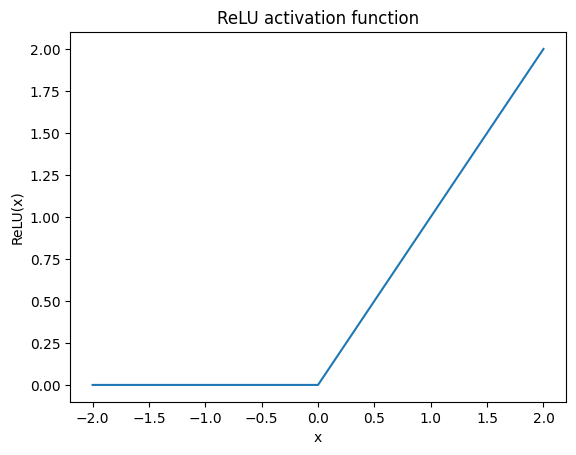

In [11]:
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)
plt.plot(x, tf.nn.relu(x));
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.title('ReLU activation function');

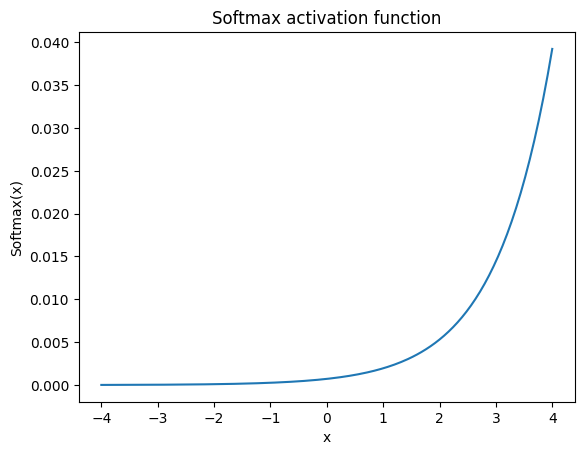

In [12]:
x = tf.linspace(-4, 4, 201)
x = tf.cast(x, tf.float32)
plt.plot(x, tf.nn.softmax(x, axis=0));
plt.xlabel('x')
plt.ylabel('Softmax(x)')
plt.title('Softmax activation function');

In [13]:
def xavier_init(shape):
  # Computes the xavier initialization values for a weight matrix
  in_dim, out_dim = shape
  xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))
  weight_vals = tf.random.uniform(shape=(in_dim, out_dim), 
                                  minval=-xavier_lim, maxval=xavier_lim, seed=22)
  return weight_vals

In [14]:
class DenseLayer(tf.Module):

  def __init__(self, out_dim, weight_init=xavier_init, activation=tf.identity):
    # Initialize the dimensions and activation functions
    self.out_dim = out_dim
    self.weight_init = weight_init
    self.activation = activation
    self.built = False

  def __call__(self, x):
    if not self.built:
      # Infer the input dimension based on first call
      self.in_dim = x.shape[1]                                                  
      # Initialize the weights and biases
      self.w = tf.Variable(self.weight_init(shape=(self.in_dim, self.out_dim)))
      self.b = tf.Variable(tf.zeros(shape=(self.out_dim,)))
      self.built = True
    # Compute the forward pass
    z = tf.add(tf.matmul(x, self.w), self.b)
    return self.activation(z)

In [15]:
class MLP(tf.Module):

  def __init__(self, layers):
    self.layers = layers

  @tf.function
  def __call__(self, x, preds=False): 
    # Execute the model's layers sequentially
    for layer in self.layers:
      x = layer(x)
    return x

In [16]:
hidden_layer_1_size = 200
hidden_layer_2_size = 100
hidden_layer_3_size = 100
hidden_layer_4_size = 50
output_size = 5

mlp_model = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_3_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_4_size, activation=tf.nn.relu),
    DenseLayer(out_dim=output_size)])

In [17]:
def cross_entropy_loss(y_pred, y):
  # Compute cross entropy loss with a sparse operation
  sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(sparse_ce)

In [18]:
def accuracy(y_pred, y):
  # Compute accuracy after extracting class predictions
  class_preds = tf.argmax(tf.nn.softmax(y_pred), axis=1)
  is_equal = tf.equal(y, class_preds)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

In [19]:
class Adam:

    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
      # Initialize optimizer parameters and variable slots
      self.beta_1 = beta_1
      self.beta_2 = beta_2
      self.learning_rate = learning_rate
      self.ep = ep
      self.t = 1.
      self.v_dvar, self.s_dvar = [], []
      self.built = False

    def apply_gradients(self, grads, vars):
      # Initialize variables on the first call
      if not self.built:
        for var in vars:
          v = tf.Variable(tf.zeros(shape=var.shape))
          s = tf.Variable(tf.zeros(shape=var.shape))
          self.v_dvar.append(v)
          self.s_dvar.append(s)
        self.built = True
      # Update the model variables given their gradients
      for i, (d_var, var) in enumerate(zip(grads, vars)):
        self.v_dvar[i].assign(self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var)
        self.s_dvar[i].assign(self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var))
        v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
        s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
        var.assign_sub(self.learning_rate*(v_dvar_bc/(tf.sqrt(s_dvar_bc) + self.ep)))
      self.t += 1.
      return

In [20]:
def train_step(x_batch, y_batch, loss, acc, model, optimizer):
  # Update the model state given a batch of data
  with tf.GradientTape() as tape:
    y_pred = model(x_batch)
    batch_loss = loss(y_pred, y_batch)
  batch_acc = acc(y_pred, y_batch)
  grads = tape.gradient(batch_loss, model.variables)
  optimizer.apply_gradients(grads, model.variables)
  return batch_loss, batch_acc

def val_step(x_batch, y_batch, loss, acc, model):
  # Evaluate the model on given a batch of validation data
  y_pred = model(x_batch)
  batch_loss = loss(y_pred, y_batch)
  batch_acc = acc(y_pred, y_batch)
  return batch_loss, batch_acc

In [21]:
def train_model(mlp, train_data, val_data, loss, acc, optimizer, epochs):
  # Initialize data structures
  train_losses, train_accs = [], []
  val_losses, val_accs = [], []

  # Format training loop and begin training
  for epoch in range(epochs):
    batch_losses_train, batch_accs_train = [], []
    batch_losses_val, batch_accs_val = [], []

    # Iterate over the training data
    for x_batch, y_batch in train_data:
      # Compute gradients and update the model's parameters
      batch_loss, batch_acc = train_step(x_batch, y_batch, loss, acc, mlp, optimizer)
      # Keep track of batch-level training performance
      batch_losses_train.append(batch_loss)
      batch_accs_train.append(batch_acc)
      

    # Iterate over the validation data
    for x_batch, y_batch in val_data:
      batch_loss, batch_acc = val_step(x_batch, y_batch, loss, acc, mlp)
      batch_losses_val.append(batch_loss)
      batch_accs_val.append(batch_acc)

    # Keep track of epoch-level model performance
    train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
    val_loss, val_acc = tf.reduce_mean(batch_losses_val), tf.reduce_mean(batch_accs_val)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch: {epoch}")
    print(f"Training loss: {train_loss:.3f}, Training accuracy: {train_acc:.3f}")
    print(f"Validation loss: {val_loss:.3f}, Validation accuracy: {val_acc:.3f}")
  return train_losses, train_accs, val_losses, val_accs

In [22]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data, val_data, 
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=Adam(), epochs=20)

Epoch: 0
Training loss: 1.423, Training accuracy: 0.368
Validation loss: 1.277, Validation accuracy: 0.472
Epoch: 1
Training loss: 1.280, Training accuracy: 0.453
Validation loss: 1.246, Validation accuracy: 0.487
Epoch: 2
Training loss: 1.252, Training accuracy: 0.458
Validation loss: 1.230, Validation accuracy: 0.508
Epoch: 3
Training loss: 1.227, Training accuracy: 0.474
Validation loss: 1.204, Validation accuracy: 0.509
Epoch: 4
Training loss: 1.193, Training accuracy: 0.500
Validation loss: 1.196, Validation accuracy: 0.497
Epoch: 5
Training loss: 1.151, Training accuracy: 0.522
Validation loss: 1.182, Validation accuracy: 0.509
Epoch: 6
Training loss: 1.107, Training accuracy: 0.538
Validation loss: 1.182, Validation accuracy: 0.499
Epoch: 7
Training loss: 1.068, Training accuracy: 0.554
Validation loss: 1.204, Validation accuracy: 0.489
Epoch: 8
Training loss: 1.031, Training accuracy: 0.572
Validation loss: 1.220, Validation accuracy: 0.495
Epoch: 9
Training loss: 1.006, Traini

In [23]:
def plot_metrics(train_metric, val_metric, metric_type):
  # Visualize metrics vs training Epochs
  plt.figure()
  plt.plot(range(len(train_metric)), train_metric, label = f"Training {metric_type}")
  plt.plot(range(len(val_metric)), val_metric, label = f"Validation {metric_type}")
  plt.xlabel("Epochs")
  plt.ylabel(metric_type)
  plt.legend()
  plt.title(f"{metric_type} vs Training epochs");

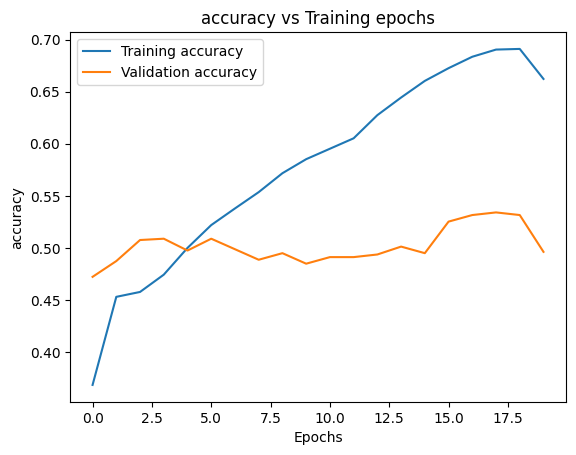

In [24]:
plot_metrics(train_accs, val_accs, "accuracy")

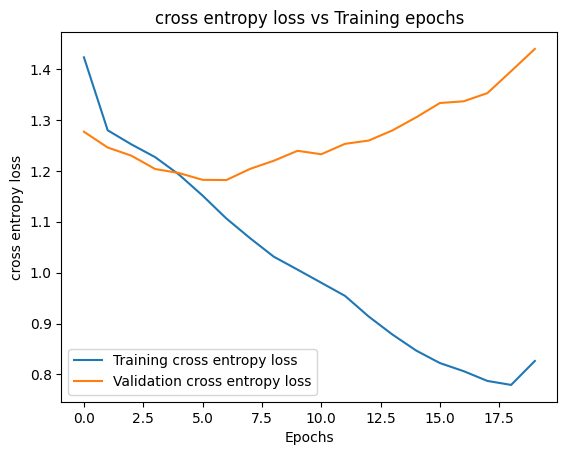

In [25]:
plot_metrics(train_losses, val_losses, "cross entropy loss")

In [26]:
class ExportModule(tf.Module):
  def __init__(self, model, preprocess, class_pred):
    # Initialize pre and postprocessing functions
    self.model = model
    self.preprocess = preprocess
    self.class_pred = class_pred

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, 200], dtype=tf.float32)]) 
  def __call__(self, x):
    # Run the ExportModule for new data points
    x = self.preprocess(x)
    y = self.model(x)
    print(y)
    y = self.class_pred(y)
    return y

In [27]:
def preprocess_test(x):
  return x

def class_pred_test(y):
  # Generate class predictions from MLP output
  return tf.argmax(tf.nn.softmax(y), axis=1)

In [28]:
mlp_model_export = ExportModule(model=mlp_model,
                                preprocess=preprocess_test,
                                class_pred=class_pred_test)

In [29]:
import tempfile
import os

In [30]:
save_path = 'RWMD-MP50'
tf.saved_model.save(mlp_model_export, save_path)

Tensor("StatefulPartitionedCall:0", shape=(None, 5), dtype=float32)
INFO:tensorflow:Assets written to: RWMD-MP50/assets


INFO:tensorflow:Assets written to: RWMD-MP50/assets


In [31]:
mlp_loaded = tf.saved_model.load(save_path)

In [32]:
def accuracy_score(y_pred, y):
  # Generic accuracy function
  is_equal = tf.equal(y_pred, y)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

test_classes = mlp_loaded(test_data[0])
test_acc = accuracy_score(test_classes, test_data[1])
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.426


In [36]:
from img_doc.extractors.block_extractors.block_label_extractor import MLPRandomWalkManyDistExtractor

In [77]:
mlp = MLPRandomWalkManyDistExtractor({"model_file": save_path, "len_vec": 50, "lib_model": "tf"})

In [78]:
from img_doc.data_structures import Image

In [79]:
image = Image()

In [80]:
image.set_img_from_path("../examples/img/1.jpg")

In [81]:
from img_doc.extractors.block_extractors.block_extractor_from_word import KMeanBlockExtractor
from img_doc.extractors.word_extractors import TesseractWordExtractor

words_ext = TesseractWordExtractor()
block_ext = KMeanBlockExtractor()

In [82]:
words = words_ext.extract_from_img(image.img)

In [83]:
blocks = block_ext.extract_from_word(words, {})

In [90]:
words_ = blocks[1].words
vec = mlp.get_vec_from_words(words_, len_vec=mlp.param["len_vec"])
rez = mlp.load_model(np.array([vec], dtype="float32"))[0]

In [85]:
import matplotlib.pyplot as plt

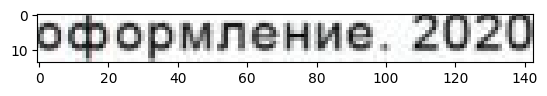

In [88]:
plt.imshow(blocks[1].segment.get_segment_from_img(image.img))